In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [15]:
sns.set(style='whitegrid')
sns.set_palette("pastel")

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# Decay Rate

In [16]:
emotion_groups_ekman = {
    'happiness': ['joy', 'amusement', 'excitement', 'pride', 'gratitude', 'relief', 'love', 'caring'],
    'sadness': ['sadness', 'disappointment', 'remorse', 'grief'],
    'anger': ['anger', 'annoyance', 'disapproval'],
    'fear': ['fear', 'nervousness'],
    'disgust': ['disgust', 'embarrassment'],
    'surprise': ['surprise', 'realization', 'confusion'],
}

In [17]:
def exp_decay(t, A, k):
    return A * np.exp(-k * t)

def segment_decay_fit(y, prominence=0.005, window=10, plot_title="Segment Decay Fitting"):
    t = np.arange(len(y))
    peaks, _ = find_peaks(y, prominence=prominence)
    decay_rates, peak_indices = [], []

    plt.figure(figsize=(15, 8))
    plt.plot(t, y, label='Original Signal', color='gray')

    for peak in peaks:
        t_seg = np.arange(window)
        y_seg = y[peak:peak + window]
        if len(y_seg) < window or np.any(np.isnan(y_seg)):
            continue
        try:
            params, _ = curve_fit(exp_decay, t_seg, y_seg, p0=(y_seg[0], 0.1), maxfev=10000)
            A, k = params
            if k > 0:
                decay_rates.append(k)
                peak_indices.append(peak)
                plt.plot(peak + t_seg, exp_decay(t_seg, *params), label=f'Emotion: {plot_title}, Peak@{peak}, k={k:.3f}')
        except:
            continue

    plt.title(f"{plot_title} - Emotion Decay")
    plt.xlabel("Time Index")
    plt.ylabel("Emotion Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({
        "peak_index": peak_indices,
        "decay_rate_k": decay_rates,
        "half_life_weeks": [np.log(2) / k if k > 0 else np.nan for k in decay_rates]
    })

def process_platform_emotions_monthly_smoothed(path, date_col, window=3):
    df = pd.read_csv(path)
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce').dt.tz_localize(None)
    df = df.dropna(subset=[date_col])
    
    df['week'] = df[date_col].dt.to_period('W').apply(lambda r: r.start_time)
    
    for group, emotions in emotion_groups_ekman.items():
        df[group] = df[emotions].mean(axis=1)
    
    monthly_df = df.groupby('week')[list(emotion_groups_ekman.keys())].mean().reset_index()
    
    for group in emotion_groups_ekman.keys():
        monthly_df[group] = monthly_df[group].rolling(window=window, min_periods=1).mean()
    
    return monthly_df

def analyze_all_emotions(weekly_df, platform_label):
    all_results = []
    for emotion in emotion_groups_ekman.keys():
        decay_df = segment_decay_fit(weekly_df[emotion].values, prominence=0.002, window=12, plot_title=emotion)
        decay_df["emotion"] = emotion
        decay_df["platform"] = platform_label
        all_results.append(decay_df)
    return pd.concat(all_results, ignore_index=True)

def remove_outliers_iqr(df, col='half_life_weeks'):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)].copy()

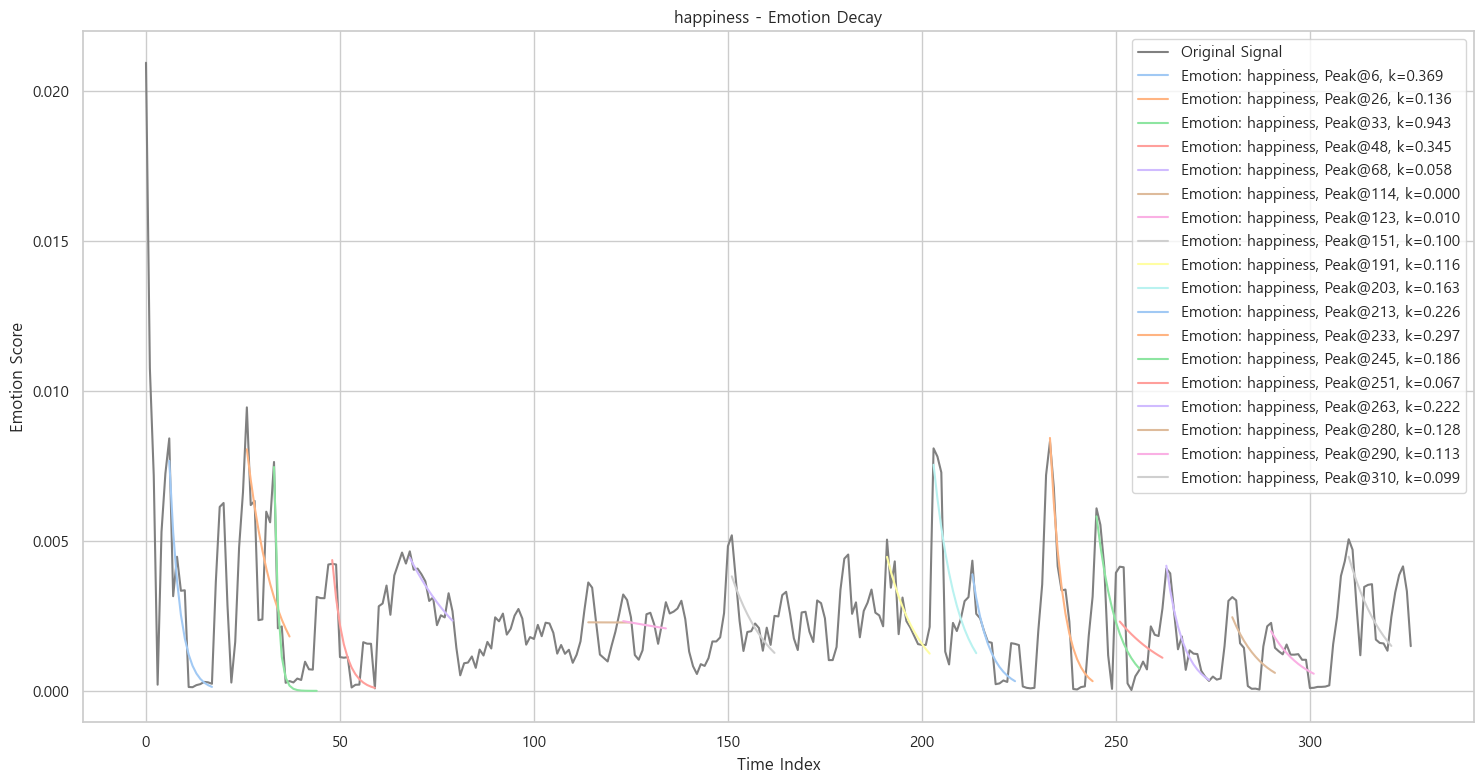

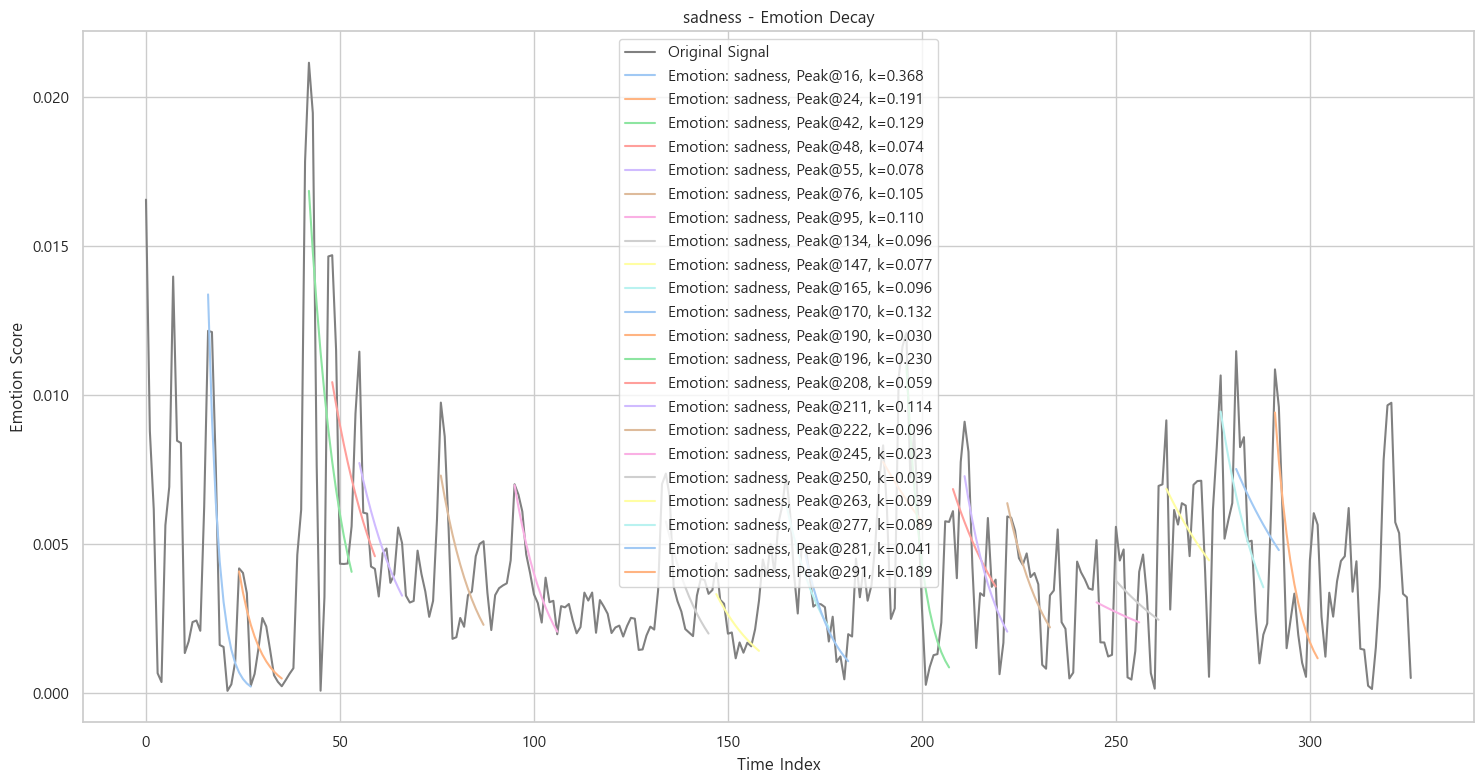

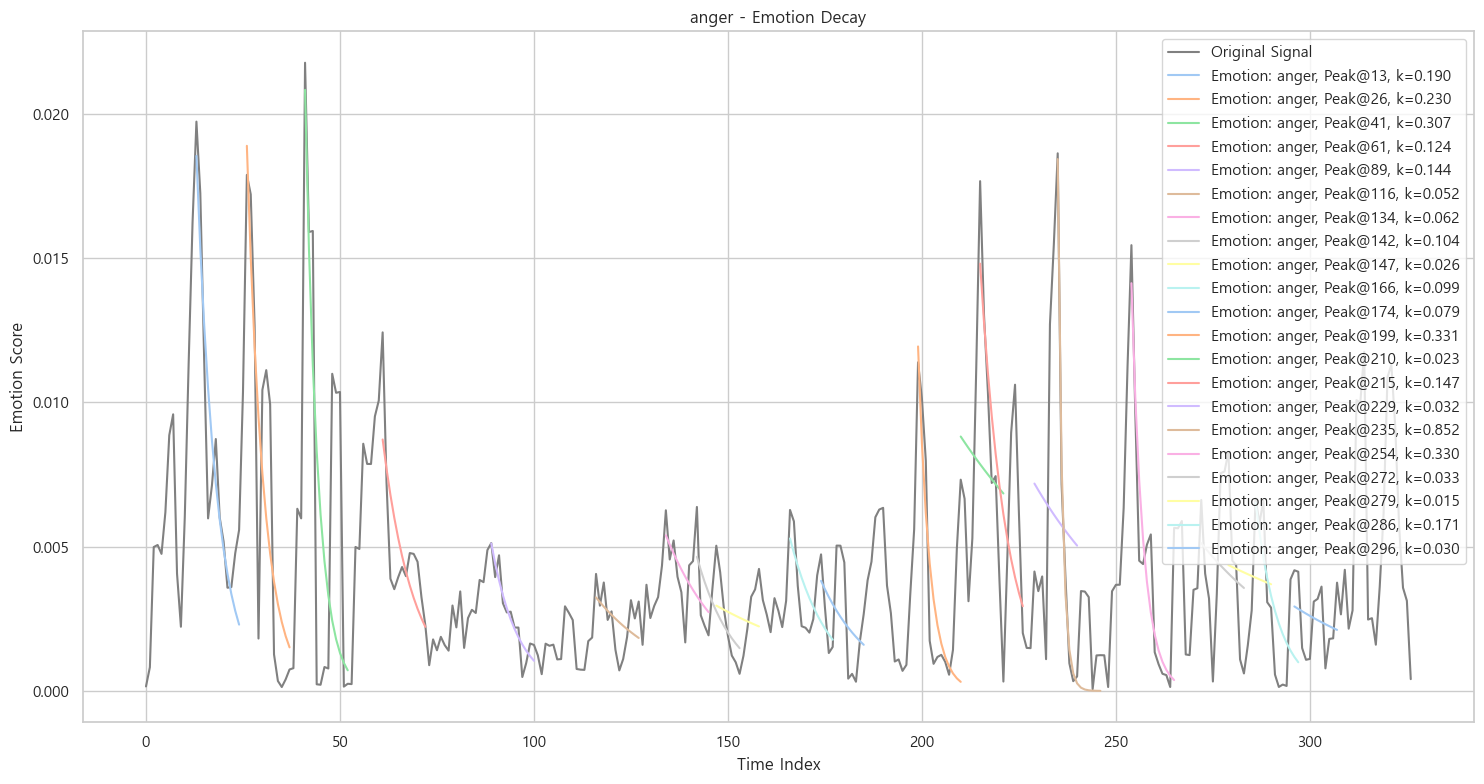

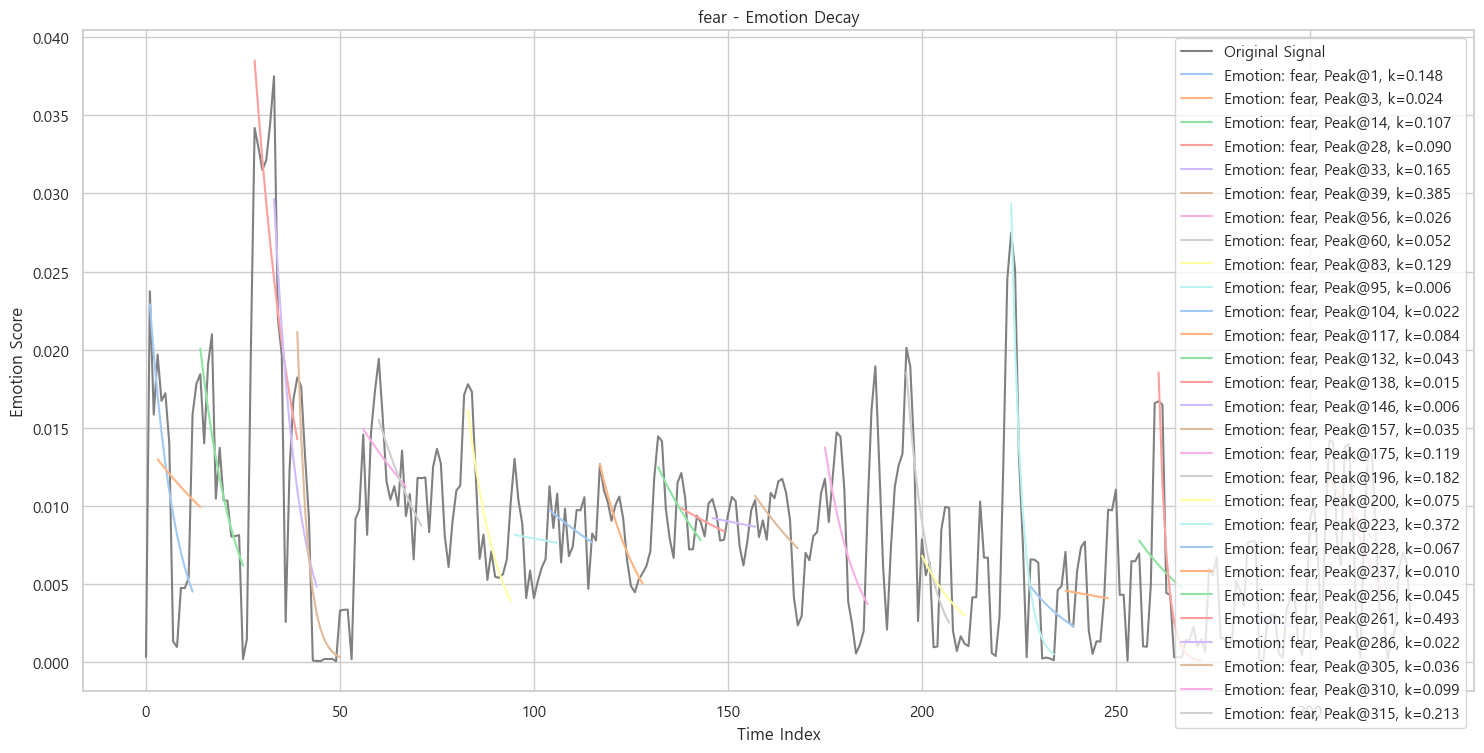

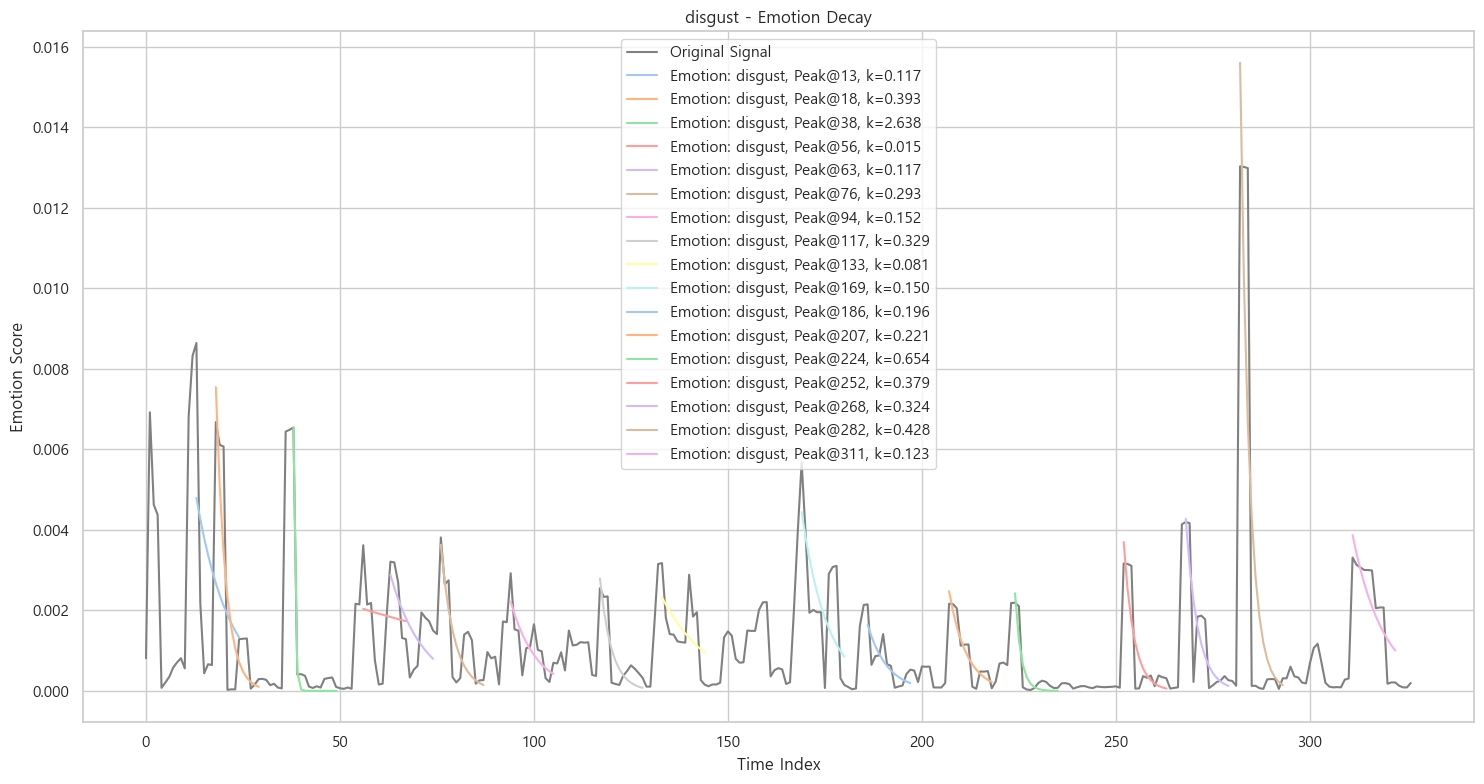

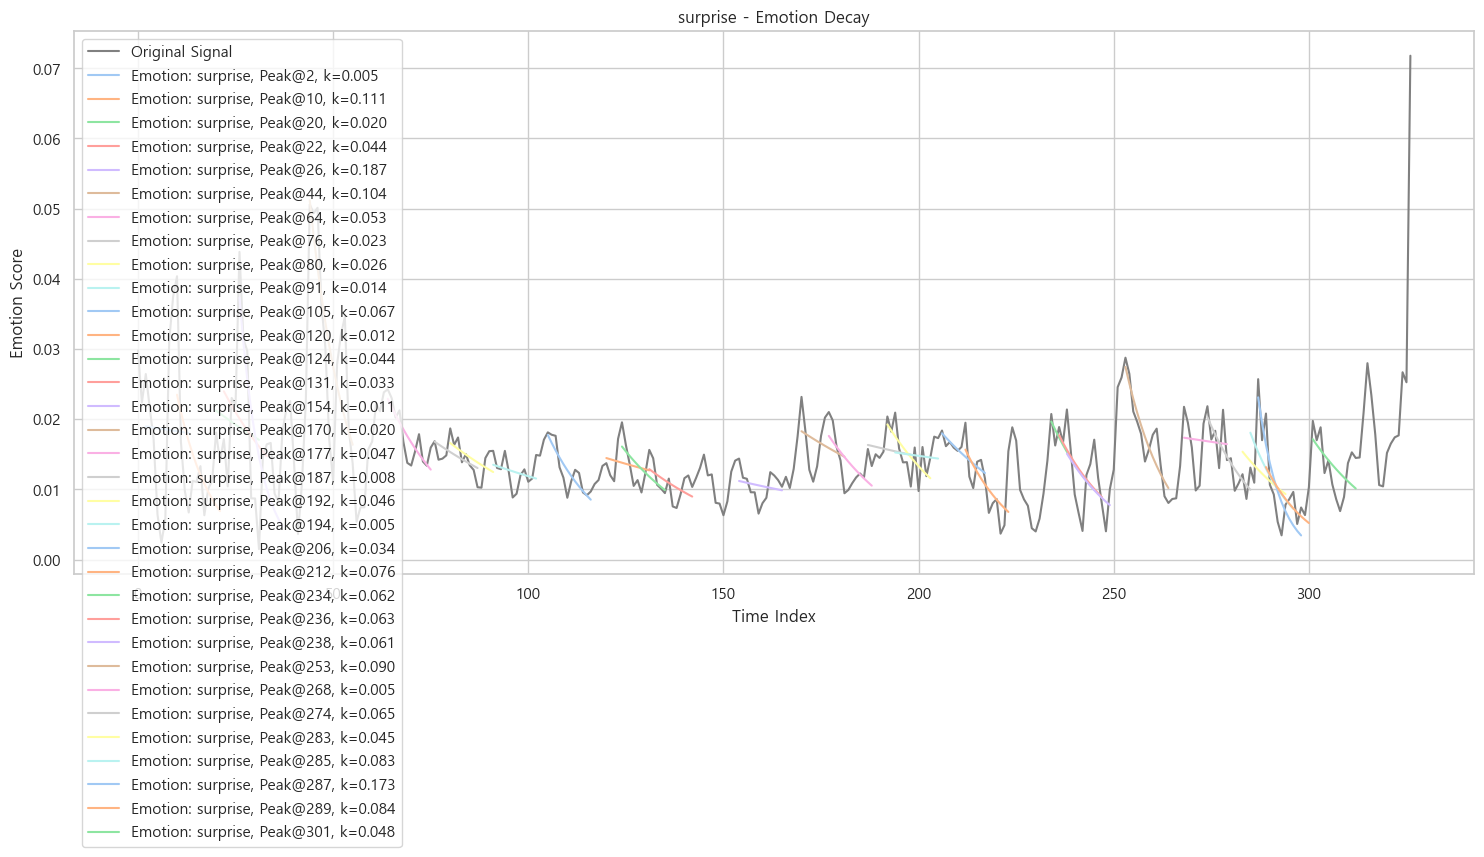

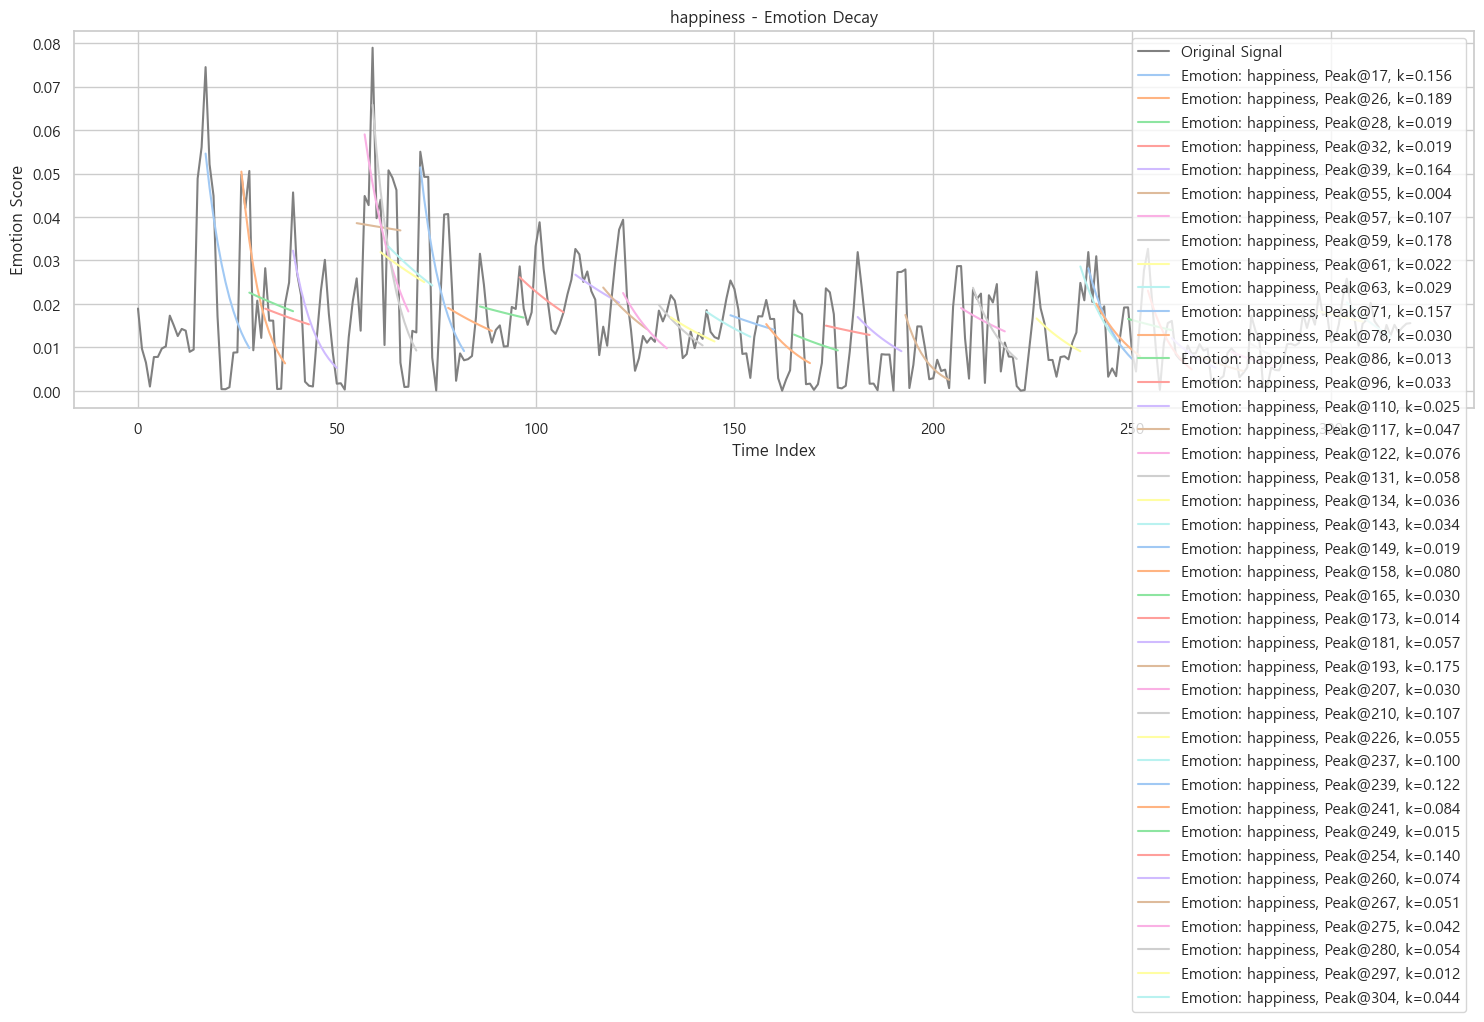

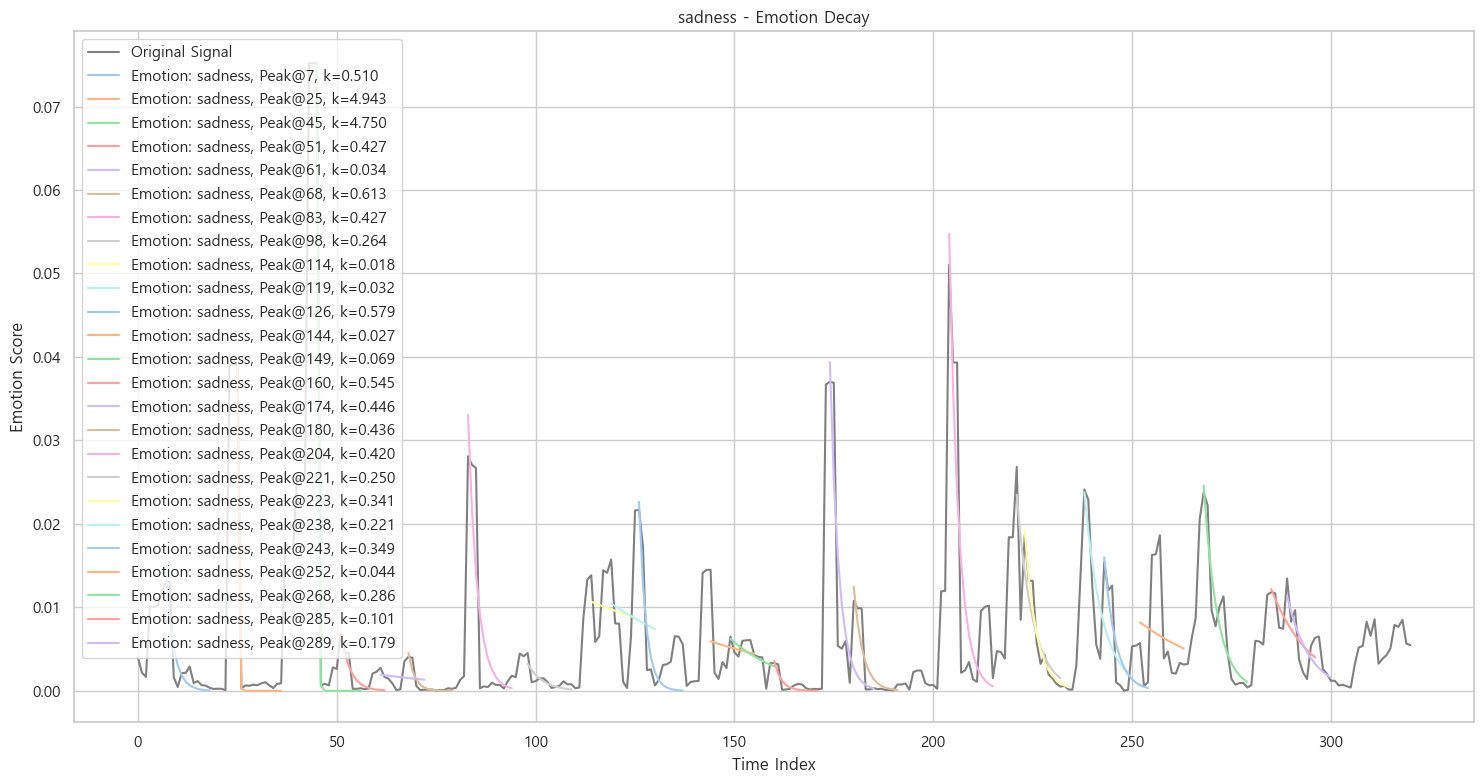

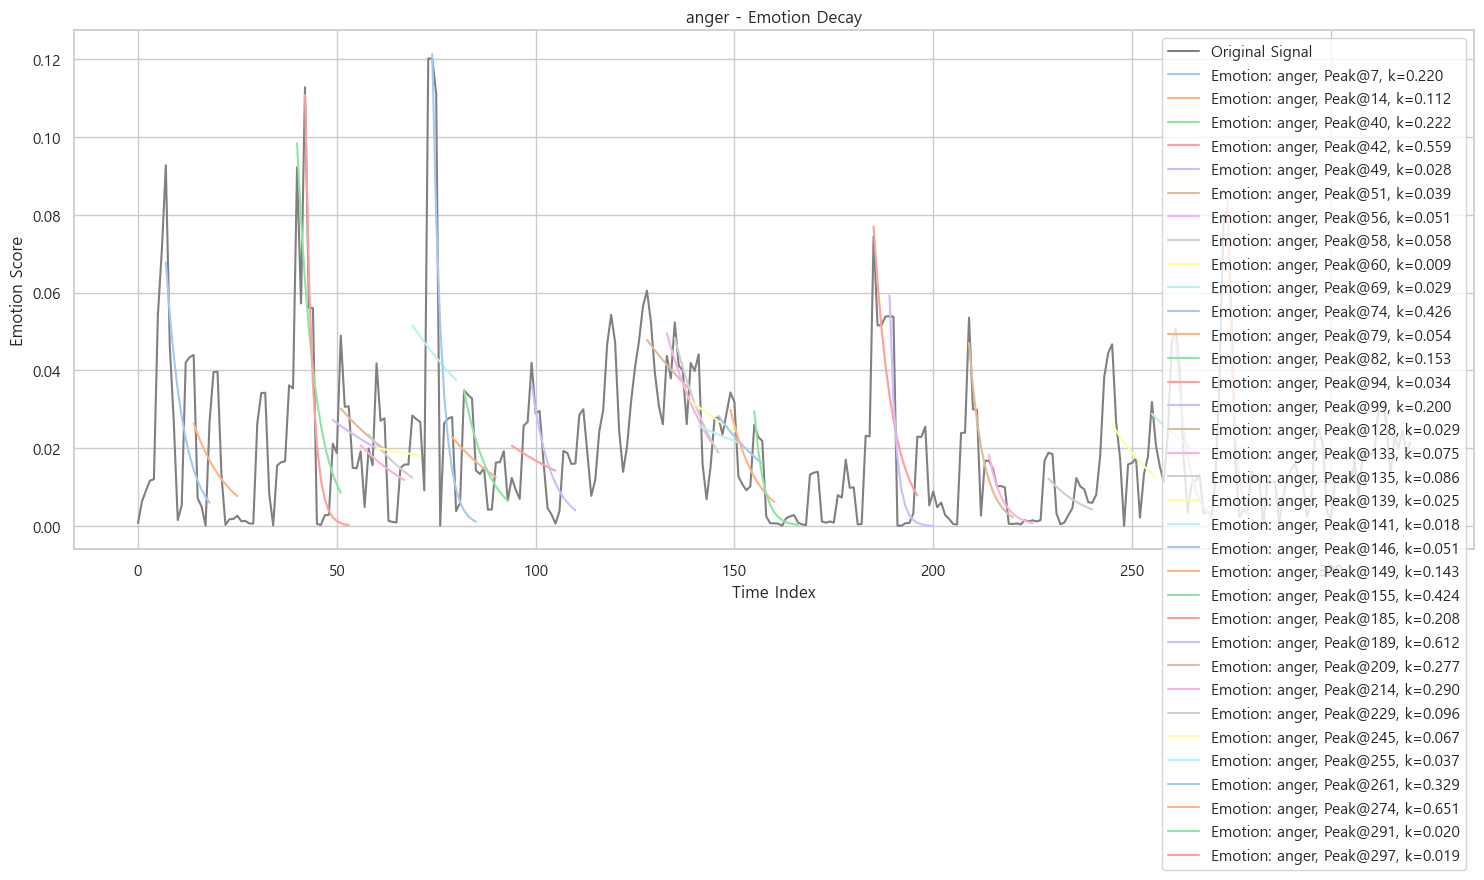

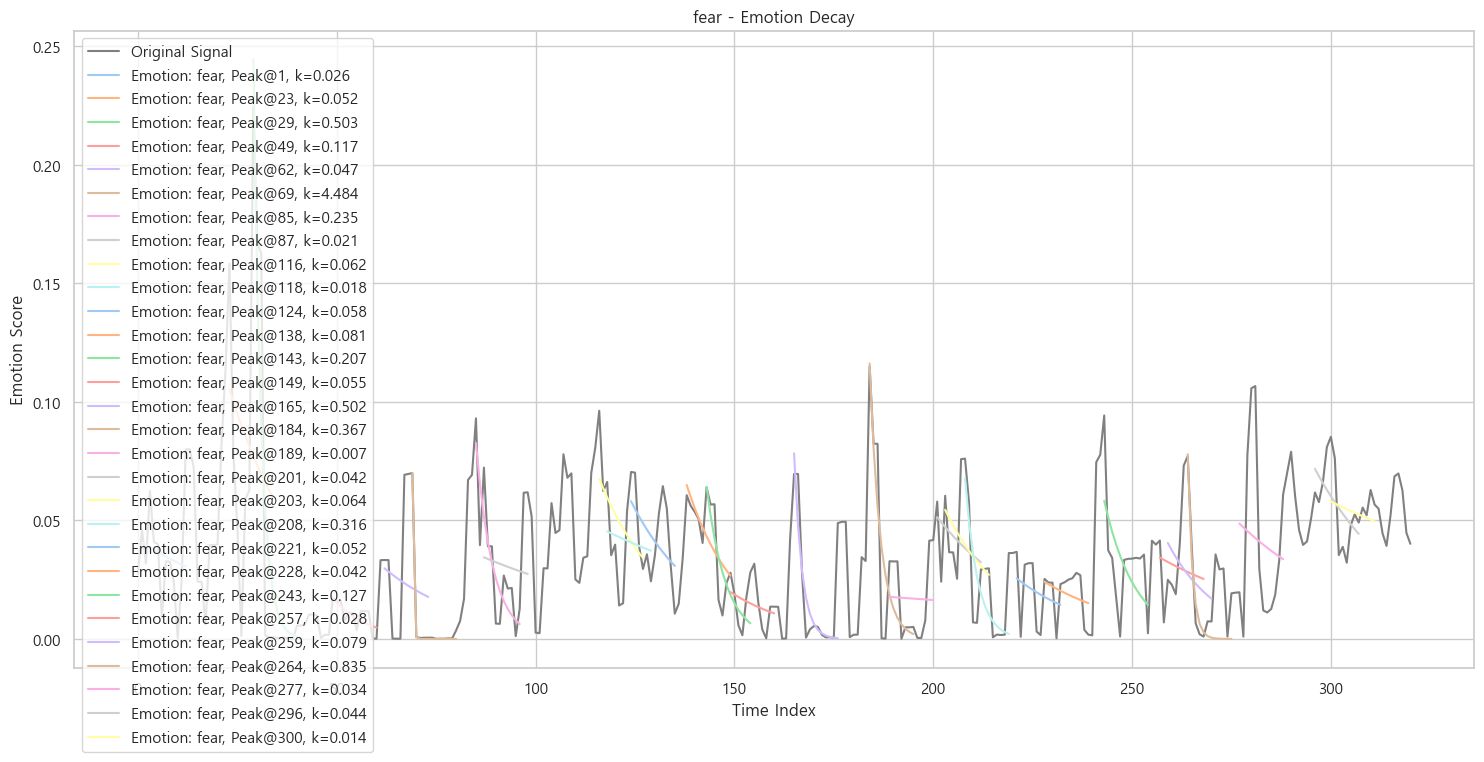

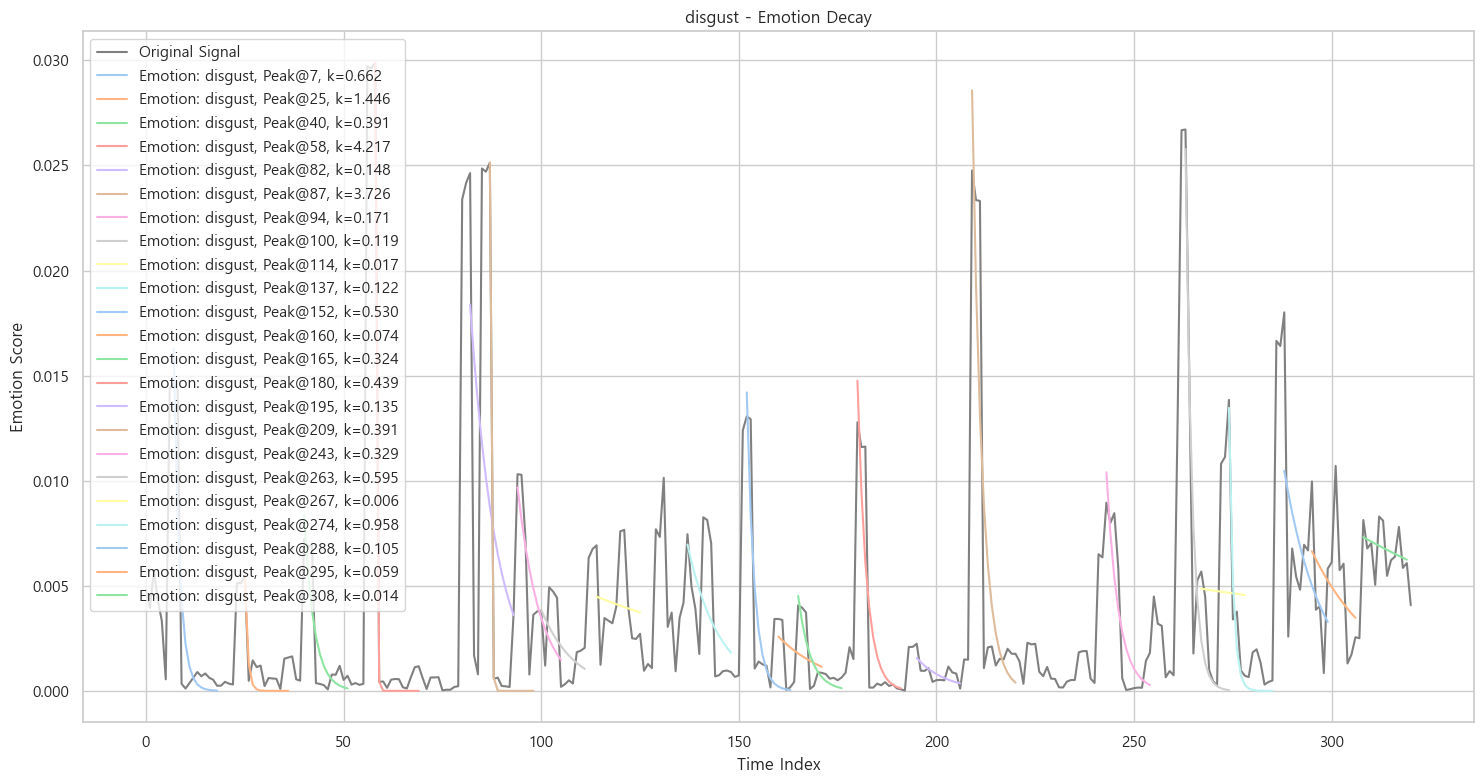

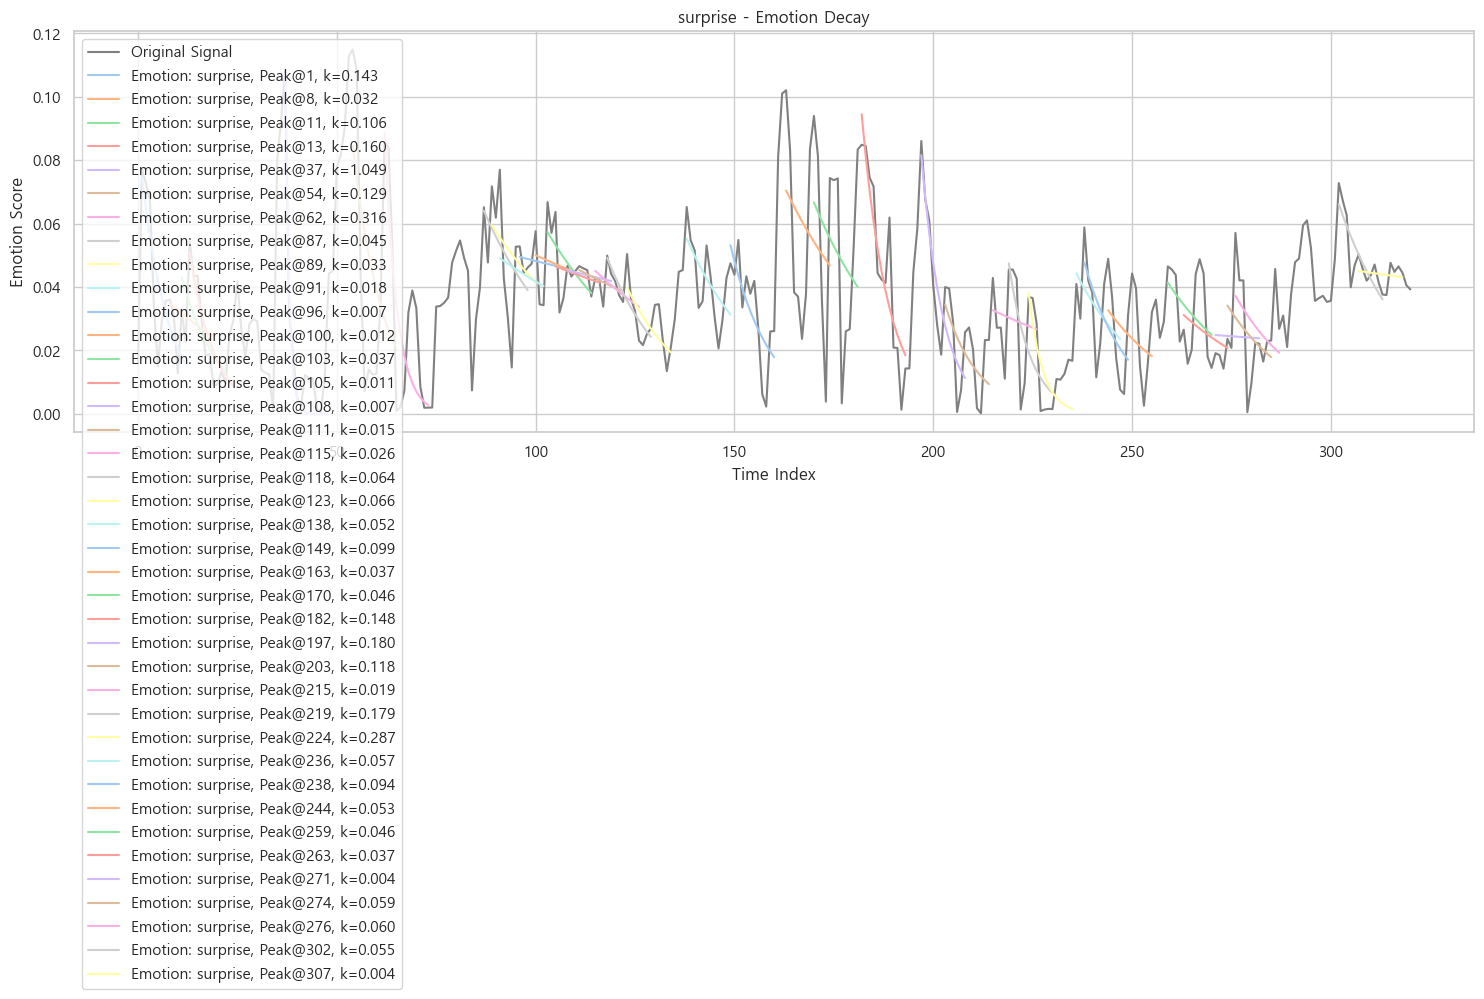

In [18]:
# 파일 로드 및 처리
smoothed_public = process_platform_emotions_monthly_smoothed('./ready/public_media_vaccine.csv', 'pub_date')
smoothed_civil = process_platform_emotions_monthly_smoothed('./ready/civil_platform_vaccine.csv', 'pub_date')

# 전체 감정 분석
summary_public = analyze_all_emotions(smoothed_public, "Public Media")
summary_civil = analyze_all_emotions(smoothed_civil, "Civil Platform")
summary_all = pd.concat([summary_public, summary_civil], ignore_index=True)

summary_filtered = remove_outliers_iqr(summary_all)

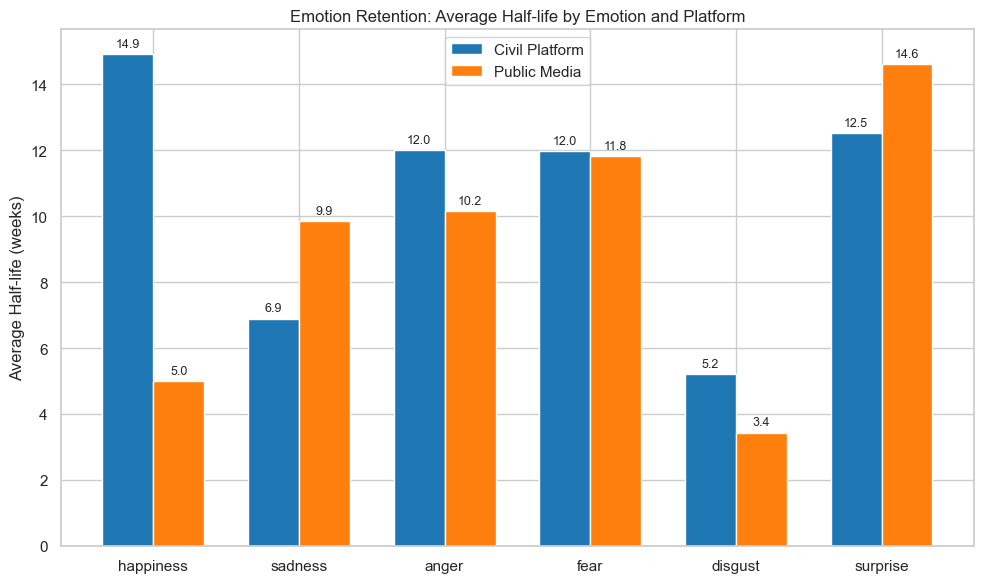

In [19]:
# 평균 half-life 계산
mean_half_life = summary_filtered.groupby(['emotion', 'platform'])['half_life_weeks'].mean().reset_index()

# 시각화 코드
sns.set(style="whitegrid")
emotion_order = ['happiness', 'sadness', 'anger', 'fear', 'disgust', 'surprise']
mean_half_life["emotion"] = pd.Categorical(mean_half_life["emotion"], categories=emotion_order, ordered=True)
mean_half_life = mean_half_life.sort_values(["emotion", "platform"])

pivot = mean_half_life.pivot(index="emotion", columns="platform", values="half_life_weeks")
platforms = pivot.columns.tolist()
x = np.arange(len(pivot))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, pivot[platforms[0]], width, label=platforms[0], color="#1f77b4")
bars2 = ax.bar(x + width/2, pivot[platforms[1]], width, label=platforms[1], color="#ff7f0e")

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

ax.set_ylabel("Average Half-life (weeks)")
ax.set_title("Emotion Retention: Average Half-life by Emotion and Platform")
ax.set_xticks(x)
ax.set_xticklabels(pivot.index)
ax.legend()
plt.tight_layout()
plt.show()

In [20]:
# civil과 public의 전체 평균 half-life 계산 및 비교
platform_avg = summary_filtered.groupby('platform')['half_life_weeks'].mean().reset_index()

print("Average Half-life by Platform:")
for _, row in platform_avg.iterrows():
    print(f"{row['platform']}: {row['half_life_weeks']:.2f} weeks")

Average Half-life by Platform:
Civil Platform: 11.13 weeks
Public Media: 9.83 weeks


# Auto Correlation

In [21]:
def process_platform_emotions(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce').dt.tz_localize(None)
    df = df.dropna(subset=[date_col])
    df['week'] = df[date_col].dt.to_period('W').apply(lambda r: r.start_time)

    for group, emotions in emotion_groups_ekman.items():
        df[group] = df[emotions].mean(axis=1)

    weekly_df = df.groupby('week')[list(emotion_groups_ekman.keys())].mean().reset_index()
    return weekly_df

def compute_autocorrelation(df, platform_name):
    results = []
    for emotion in emotion_groups:
        series = df[emotion]
        if series.isnull().sum() > 0:
            series = series.dropna()

        if len(series) > 1:
            autocorr = series.autocorr(lag=1)
        else:
            autocorr = None

        results.append({
            'platform': platform_name,
            'emotion': emotion,
            'autocorrelation_lag1': autocorr
        })
    return pd.DataFrame(results)

In [22]:
emotion_groups = ['happiness', 'sadness', 'anger', 'fear', 'disgust', 'surprise']

public = pd.read_csv('./ready/public_media_vaccine.csv', encoding='utf-8-sig')
civil = pd.read_csv('./ready/civil_platform_vaccine.csv', encoding='utf-8-sig')

weekly_public = process_platform_emotions(public, 'pub_date')
weekly_civil = process_platform_emotions(civil, 'pub_date')

weekly_civil_smoothed = weekly_civil.copy()
for emotion in emotion_groups:
    weekly_civil_smoothed[emotion] = weekly_civil[emotion].rolling(window=3, center=True).mean()
weekly_civil_smoothed = weekly_civil_smoothed.dropna()

autocorr_public = compute_autocorrelation(weekly_public, 'Public Media')
autocorr_civil = compute_autocorrelation(weekly_civil_smoothed, 'Civil Platform')

autocorr_results = pd.concat([autocorr_public, autocorr_civil], ignore_index=True)

print("\n[AutoCorrelation Results]")
print(autocorr_results)


[AutoCorrelation Results]
          platform    emotion  autocorrelation_lag1
0     Public Media  happiness              0.035944
1     Public Media    sadness              0.091713
2     Public Media      anger              0.087751
3     Public Media       fear              0.129912
4     Public Media    disgust             -0.039078
5     Public Media   surprise              0.040214
6   Civil Platform  happiness              0.637441
7   Civil Platform    sadness              0.687540
8   Civil Platform      anger              0.672790
9   Civil Platform       fear              0.654907
10  Civil Platform    disgust              0.619698
11  Civil Platform   surprise              0.684321


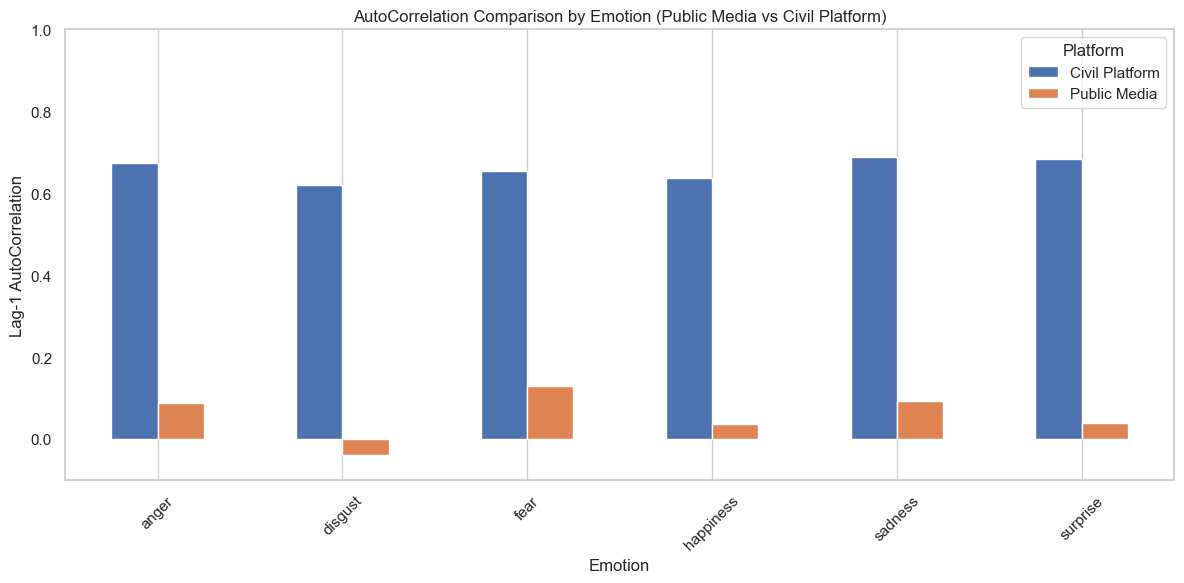

In [23]:
pivot_autocorr = autocorr_results.pivot(index='emotion', columns='platform', values='autocorrelation_lag1')

pivot_autocorr.plot(kind='bar', figsize=(12, 6))

plt.title('AutoCorrelation Comparison by Emotion (Public Media vs Civil Platform)')
plt.xlabel('Emotion')
plt.ylabel('Lag-1 AutoCorrelation')
plt.xticks(rotation=45)
plt.ylim(-0.1, 1.0)
plt.grid(axis='y')
plt.legend(title='Platform')
plt.tight_layout()
plt.show()

# Figure

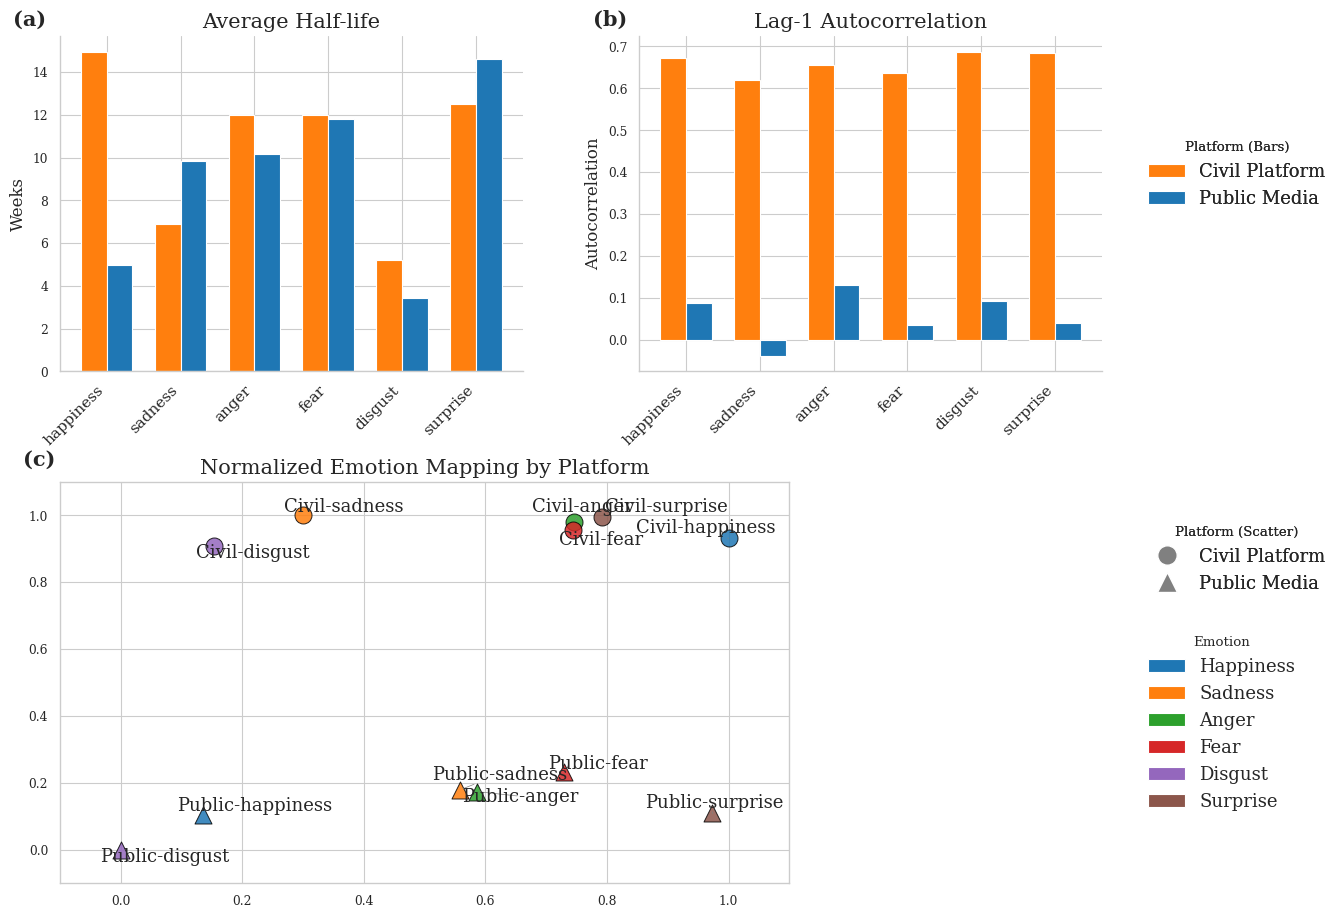

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from adjustText import adjust_text
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# --- 이전 코드의 결과물이 이미 있다고 가정합니다 ---
# pivot_half, pivot_autocorr 변수가 준비된 상태
pivot_half = pivot

# --- 1. 데이터 준비 ---
emotion_order = ['happiness', 'sadness', 'anger', 'fear', 'disgust', 'surprise']
platforms = pivot_half.columns.tolist()

df_half = (
    pivot_half
    .reset_index()
    .rename(columns={'emotion': 'Emotion'})
    .melt(id_vars='Emotion', var_name='Platform', value_name='Half-life')
)
df_ac = (
    pivot_autocorr
    .reset_index()
    .rename(columns={'emotion': 'Emotion'})
    .melt(id_vars='Emotion', var_name='Platform', value_name='Autocorrelation')
)
df_plot = pd.merge(df_half, df_ac, on=['Emotion', 'Platform'])

scaler = MinMaxScaler()
df_plot[['Half-life_norm', 'Autocorrelation_norm']] = scaler.fit_transform(
    df_plot[['Half-life', 'Autocorrelation']]
)


# --- 2. 시각화 설정 ---
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.titleweight'] = 'normal'

platform_colors = {'Public Media': '#1f77b4', 'Civil Platform': '#ff7f0e'}
emotion_colors = {
    e: c for e, c in zip(emotion_order, plt.colormaps['tab10'].colors)
}
platform_markers = {'Civil Platform': 'o', 'Public Media': '^'}


# --- 3. 그래프 그리기 ---
fig = plt.figure(figsize=(15, 11))
gs = fig.add_gridspec(
    2, 2,
    height_ratios=[1, 1.2],
    right=0.82,
    hspace=0.3,
    wspace=0.25
)

# (a) Half-life 막대그래프
ax1 = fig.add_subplot(gs[0, 0])
x = np.arange(len(emotion_order))
width = 0.35
for i, platform in enumerate(platforms):
    offset = width * (i - 0.5)
    ax1.bar(x + offset, pivot_half[platform], width,
            color=platform_colors[platform], label=platform)
ax1.set_title('Average Half-life', fontsize=15)
ax1.text(-0.1, 1.08, '(a)', transform=ax1.transAxes,
         fontsize=15, fontweight='bold', va='top')
ax1.set_ylabel('Weeks', fontsize=12)
ax1.set_xticks(x, emotion_order, rotation=45, ha='right', fontsize=11)
ax1.spines[['top', 'right']].set_visible(False)

# (b) Autocorrelation 막대그래프
ax2 = fig.add_subplot(gs[0, 1])
for i, platform in enumerate(platforms):
    offset = width * (i - 0.5)
    ax2.bar(x + offset, pivot_autocorr[platform], width,
            color=platform_colors[platform], label=platform)
ax2.set_title('Lag-1 Autocorrelation', fontsize=15)
ax2.text(-0.1, 1.08, '(b)', transform=ax2.transAxes,
         fontsize=15, fontweight='bold', va='top')
ax2.set_ylabel('Autocorrelation', fontsize=12)
ax2.set_xticks(x, emotion_order, rotation=45, ha='right', fontsize=11)
ax2.spines[['top', 'right']].set_visible(False)

# (c) 정규화된 감성 매핑 (Scatter Plot)
ax3 = fig.add_subplot(gs[1, :])
texts = []
for _, row in df_plot.iterrows():
    x_val = row['Half-life_norm']
    y_val = row['Autocorrelation_norm']
    emo, plat = row['Emotion'], row['Platform']
    ax3.scatter(
        x_val, y_val, s=150,
        color=emotion_colors[emo],
        marker=platform_markers[plat],
        edgecolors='black', linewidth=0.7, alpha=0.85
    )
    label = f"{'Civil' if plat == 'Civil Platform' else 'Public'}-{emo}"
    texts.append(ax3.text(x_val, y_val, label, fontsize=13, fontweight='medium'))

adjust_text(
    texts, ax=ax3,
    force_text=(0.5, 0.5),
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
)

ax3.set_title('Normalized Emotion Mapping by Platform', fontsize=15)
ax3.set_xlim(-0.1, 1.1)
ax3.set_ylim(-0.1, 1.1)

ax3.text(-0.05, 1.08, '(c)', transform=ax3.transAxes,
         fontsize=15, fontweight='bold', va='top')

# — (c)만 왼쪽으로 정렬하고 폭 축소하기 —
pos1 = ax1.get_position()   # (a)의 위치 정보
pos3 = ax3.get_position()   # (c)의 원래 위치
new_width = pos3.width * 0.7    # 폭을 70%로 축소
new_x0    = pos1.x0            # (a)의 왼쪽 축과 맞춰서 정렬
ax3.set_position([new_x0, pos3.y0, new_width, pos3.height])

# --- 4. 범례 배치 ---
# 막대그래프 플랫폼 범례
handles_bar = [
    Patch(facecolor=c, label=p)
    for p, c in reversed(list(platform_colors.items()))
]
leg_bar = fig.legend(
    handles=handles_bar, title='Platform (Bars)',
    bbox_to_anchor=(0.84, 0.8), loc='upper left', fontsize=13
)
fig.add_artist(leg_bar)

# 스캐터플롯 플랫폼 범례
handles_plat = [
    Line2D([0], [0], marker=m, color='w', label=p,
           markerfacecolor='gray', markersize=14)
    for p, m in platform_markers.items()
]
leg_plat = fig.legend(
    handles=handles_plat, title='Platform (Scatter)',
    bbox_to_anchor=(0.84, 0.45), loc='upper left', fontsize=13
)
fig.add_artist(leg_plat)

# 감정 범례
handles_emo = [
    Patch(facecolor=c, label=e.capitalize())
    for e, c in emotion_colors.items()
]
fig.legend(
    handles=handles_emo, title='Emotion',
    bbox_to_anchor=(0.84, 0.35), loc='upper left', fontsize=13
)

plt.show()

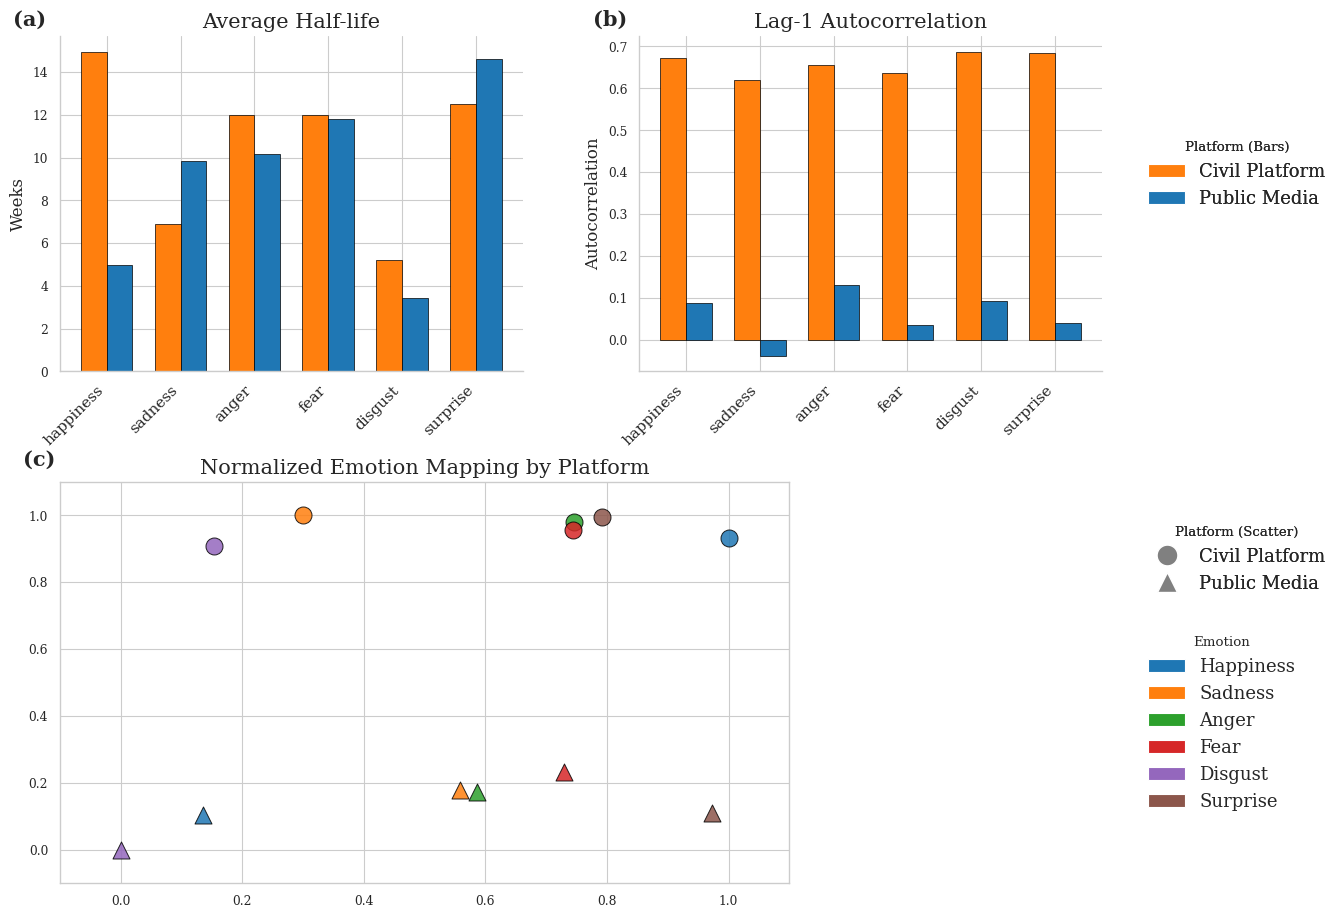

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# --- 이전 코드의 결과물이 이미 있다고 가정합니다 ---
# pivot_half, pivot_autocorr 변수가 준비된 상태
pivot_half = pivot

# --- 1. 데이터 준비 ---
emotion_order = ['happiness', 'sadness', 'anger', 'fear', 'disgust', 'surprise']
platforms = pivot_half.columns.tolist()

df_half = (
    pivot_half
    .reset_index()
    .rename(columns={'emotion': 'Emotion'})
    .melt(id_vars='Emotion', var_name='Platform', value_name='Half-life')
)
df_ac = (
    pivot_autocorr
    .reset_index()
    .rename(columns={'emotion': 'Emotion'})
    .melt(id_vars='Emotion', var_name='Platform', value_name='Autocorrelation')
)
df_plot = pd.merge(df_half, df_ac, on=['Emotion', 'Platform'])

scaler = MinMaxScaler()
df_plot[['Half-life_norm', 'Autocorrelation_norm']] = scaler.fit_transform(
    df_plot[['Half-life', 'Autocorrelation']]
)

# --- 2. 시각화 설정 ---
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.titleweight'] = 'normal'

platform_colors = {'Public Media': '#1f77b4', 'Civil Platform': '#ff7f0e'}
emotion_colors = {
    e: c for e, c in zip(emotion_order, plt.colormaps['tab10'].colors)
}
platform_markers = {'Civil Platform': 'o', 'Public Media': '^'}

# --- 3. 그래프 그리기 ---
fig = plt.figure(figsize=(15, 11))
gs = fig.add_gridspec(
    2, 2,
    height_ratios=[1, 1.2],
    right=0.82,
    hspace=0.3,
    wspace=0.25
)

# (a) Half-life 막대그래프
ax1 = fig.add_subplot(gs[0, 0])
x = np.arange(len(emotion_order))
width = 0.35
for i, platform in enumerate(platforms):
    offset = width * (i - 0.5)
    ax1.bar(
        x + offset,
        pivot_half[platform],
        width,
        color=platform_colors[platform],
        edgecolor='black',    # ← 테두리 색
        linewidth=0.5,          # ← 테두리 굵기
        label=platform
    )
ax1.set_title('Average Half-life', fontsize=15)
ax1.text(-0.1, 1.08, '(a)', transform=ax1.transAxes,
         fontsize=15, fontweight='bold', va='top')
ax1.set_ylabel('Weeks', fontsize=12)
ax1.set_xticks(x, emotion_order, rotation=45, ha='right', fontsize=11)
ax1.spines[['top', 'right']].set_visible(False)

# (b) Autocorrelation 막대그래프
ax2 = fig.add_subplot(gs[0, 1])
for i, platform in enumerate(platforms):
    offset = width * (i - 0.5)
    ax2.bar(
        x + offset,
        pivot_autocorr[platform],
        width,
        color=platform_colors[platform],
        edgecolor='black',    # ← 테두리 색
        linewidth=0.5,          # ← 테두리 굵기
        label=platform
    )
ax2.set_title('Lag-1 Autocorrelation', fontsize=15)
ax2.text(-0.1, 1.08, '(b)', transform=ax2.transAxes,
         fontsize=15, fontweight='bold', va='top')
ax2.set_ylabel('Autocorrelation', fontsize=12)
ax2.set_xticks(x, emotion_order, rotation=45, ha='right', fontsize=11)
ax2.spines[['top', 'right']].set_visible(False)

# (c) 정규화된 감성 매핑 (Scatter Plot) — 텍스트 레이블 제거
ax3 = fig.add_subplot(gs[1, :])
for _, row in df_plot.iterrows():
    ax3.scatter(
        row['Half-life_norm'],
        row['Autocorrelation_norm'],
        s=150,
        color=emotion_colors[row['Emotion']],
        marker=platform_markers[row['Platform']],
        edgecolors='black',
        linewidth=0.7,
        alpha=0.85
    )

ax3.set_title('Normalized Emotion Mapping by Platform', fontsize=15)
ax3.set_xlim(-0.1, 1.1)
ax3.set_ylim(-0.1, 1.1)
ax3.text(-0.05, 1.08, '(c)', transform=ax3.transAxes,
         fontsize=15, fontweight='bold', va='top')

# — (c)만 왼쪽으로 정렬하고 폭 축소하기 —
pos1 = ax1.get_position()
pos3 = ax3.get_position()
new_width = pos3.width * 0.7
new_x0 = pos1.x0
ax3.set_position([new_x0, pos3.y0, new_width, pos3.height])

# --- 4. 범례 배치 ---
# 막대그래프 플랫폼 범례
handles_bar = [
    Patch(facecolor=c, label=p)
    for p, c in reversed(list(platform_colors.items()))
]
leg_bar = fig.legend(
    handles=handles_bar, title='Platform (Bars)',
    bbox_to_anchor=(0.84, 0.8), loc='upper left', fontsize=13
)
fig.add_artist(leg_bar)

# 스캐터플롯 플랫폼 범례
handles_plat = [
    Line2D([0], [0], marker=m, color='w', label=p,
           markerfacecolor='gray', markersize=15)
    for p, m in platform_markers.items()
]
leg_plat = fig.legend(
    handles=handles_plat, title='Platform (Scatter)',
    bbox_to_anchor=(0.84, 0.45), loc='upper left', fontsize=13
)
fig.add_artist(leg_plat)

# 감정 범례
handles_emo = [
    Patch(facecolor=c, label=e.capitalize())
    for e, c in emotion_colors.items()
]
fig.legend(
    handles=handles_emo, title='Emotion',
    bbox_to_anchor=(0.84, 0.35), loc='upper left', fontsize=13
)

plt.savefig('Figure3.svg', dpi=300, bbox_inches='tight')
plt.savefig('Figure3.png', dpi=300, bbox_inches='tight',transparent=True)
plt.show()